In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import math

In [2]:
# user variables
wave_freq = 100.0 #Hz
cycles = 5
samplerate = 48000

# conversions / calculations
duration = cycles / wave_freq #sec
duration_ms = duration * 1000.0 #msec
lengthInSamps = math.ceil(duration * samplerate)

# create time axis
time = np.linspace(0, duration, lengthInSamps)

# choose a waveform
wave = signal.sawtooth(2.0*np.pi*wave_freq*time)
#wave = signal.square(2.0*np.pi*wave_freq*time, duty=(2.0*np.pi*time + 1)/2)

## Saw sweep oscilloscope

In [12]:
cutoff_freqs = [1000.0, 500.0, 250.0, 125.0]
filtered_all = [0.0] * len(cutoff_freqs)

for cut in range(len(cutoff_freqs)):
                 
    # filter parameters
    input_gain = 1.7
    cutoff = cutoff_freqs[cut]
    r = 0.8 # resonance (0.0 to 4.0)

    g = cutoff * np.pi / samplerate
    boosted_wave = wave * input_gain

    # initial values
    y = np.array([0.0, 0.0, 0.0, 0.0])  # inital guess
    errorThresh = 0.000001 # max NR error (stopping condition)
    maxIter = 0
    filtered_wave = np.zeros(len(boosted_wave))

    # state values (initially zero)
    s1 = 0.0
    s2 = 0.0
    s3 = 0.0
    s4 = 0.0

    # NR loop
    for n in range(len(boosted_wave)):
        # input (current sample)
        x = boosted_wave[n]

        i = 0
        residue = 100 # something large
        while(abs(residue) > errorThresh and i < 50):

            # F(y) using current y values
            y1 = g*(np.tanh(x-r*y[3])-np.tanh(y[0])) + s1 - y[0]
            y2 = g*(np.tanh(y[0])-np.tanh(y[1])) + s2 - y[1]
            y3 = g*(np.tanh(y[1])-np.tanh(y[2])) + s3 - y[2]
            y4 = g*(np.tanh(y[2])-np.tanh(y[3])) + s4 - y[3]
            F = np.array([y1, y2, y3, y4]).T

            # Jacobian Matrix
            J = np.array([
                [(-g*(1.0-(np.tanh(y[0])**2))-1.0), 0.0, 0.0, (g*-r*(1.0-(np.tanh(x-r*y[3])**2)))],
                [(g*(1.0-(np.tanh(y[0])**2))), (-g*(1.0-(np.tanh(y[1])**2))-1.0), 0.0, 0.0],
                [0.0, (g*(1.0-(np.tanh(y[1])**2))), (-g*(1.0-(np.tanh(y[2])**2))-1.0), 0.0],
                [0.0, 0.0, (g*(1.0-(np.tanh(y[2])**2))), (-g*(1.0-(np.tanh(y[3])**2))-1.0)]])

            # calculate next NR step
            y_est = y
            y = y - np.matmul(inv(J), F)
            residue = y[3] - y_est[3] # only care about y4 residue
            i = i + 1

        # save y
        filtered_wave[n] = y[3]

        # update states
        s1 = 2.0 * y[0] - s1
        s2 = 2.0 * y[1] - s2
        s3 = 2.0 * y[2] - s3
        s4 = 2.0 * y[3] - s4
    
    filtered_all[cut] = filtered_wave
    
# plot waveform 
plt.plot(time, wave, label="Raw")
plt.plot(time, filtered_all[0], label="1kHz")
plt.plot(time, filtered_all[1], label="500Hz")
plt.plot(time, filtered_all[2], label="250Hz")
plt.plot(time, filtered_all[3], label="125Hz")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Filtered Sawtooth")
plt.legend()
#plt.savefig('saw1.png')
plt.show()

## Saw sweep FFT

In [15]:
# user variables
wave_freq = 100.0 #Hz
cycles = 5
samplerate = 48000

# conversions / calculations
duration = 5
#duration = cycles / wave_freq #sec
duration_ms = duration * 1000.0 #msec
lengthInSamps = math.ceil(duration * samplerate)

# create time axis
time = np.linspace(0, duration, lengthInSamps)

# choose a waveform
wave = signal.sawtooth(2.0*np.pi*wave_freq*time)
#wave = signal.square(2.0*np.pi*wave_freq*time, duty=(2.0*np.pi*time + 1)/2)

# create cutoff sweep
cutoff = np.geomspace(20000.0, 20.0, lengthInSamps)




# filter parameters
input_gain = 1.3
r = 1.6 # resonance (0.0 to 4.0)

#g = cutoff * np.pi / samplerate
boosted_wave = wave * input_gain

# initial values
y = np.array([0.0, 0.0, 0.0, 0.0])  # inital guess
errorThresh = 0.000001 # max NR error (stopping condition)
maxIter = 0
filtered_wave = np.zeros(len(boosted_wave))

# state values (initially zero)
s1 = 0.0
s2 = 0.0
s3 = 0.0
s4 = 0.0

# NR loop
for n in range(len(boosted_wave)):
    
    g = cutoff[n] * np.pi / samplerate
    
    # input (current sample)
    x = boosted_wave[n]
    
    i = 0
    residue = 100 # something large
    while(abs(residue) > errorThresh and i < 50):

        # F(y) using current y values
        y1 = g*(np.tanh(x-r*y[3])-np.tanh(y[0])) + s1 - y[0]
        y2 = g*(np.tanh(y[0])-np.tanh(y[1])) + s2 - y[1]
        y3 = g*(np.tanh(y[1])-np.tanh(y[2])) + s3 - y[2]
        y4 = g*(np.tanh(y[2])-np.tanh(y[3])) + s4 - y[3]
        F = np.array([y1, y2, y3, y4]).T

        # Jacobian Matrix
        J = np.array([
            [(-g*(1.0-(np.tanh(y[0])**2))-1.0), 0.0, 0.0, (-r*g*(1.0-(np.tanh(x-r*y[3])**2)))],
            [(g*(1.0-(np.tanh(y[0])**2))), (-g*(1.0-(np.tanh(y[1])**2))-1.0), 0.0, 0.0],
            [0.0, (g*(1.0-(np.tanh(y[1])**2))), (-g*(1.0-(np.tanh(y[2])**2))-1.0), 0.0],
            [0.0, 0.0, (g*(1.0-(np.tanh(y[2])**2))), (-g*(1.0-(np.tanh(y[3])**2))-1.0)]])

        # calculate next NR step
        y_est = y
        y = y - np.matmul(inv(J), F)
        residue = y[3] - y_est[3] # only care about y4 residue
        i = i + 1
    
    # save y
    filtered_wave[n] = y[3]
    
    # update states
    s1 = 2.0 * y[0] - s1
    s2 = 2.0 * y[1] - s2
    s3 = 2.0 * y[2] - s3
    s4 = 2.0 * y[3] - s4
    
    # log max iterations
    if i > maxIter:
        maxIter = i
    
# plot waveform 
plt.plot(time, wave, label="Raw")
plt.plot(time, filtered_wave, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Filtered Waveform")
plt.legend()
plt.show()

# save audio
import scipy.io.wavfile as wav
wav.write("Saw_sweep.wav", samplerate, filtered_wave)

In [16]:
f, t, Sxx = signal.spectrogram(filtered_wave, fs=samplerate, window=('tukey', 0.25), nperseg=4096, noverlap=8, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

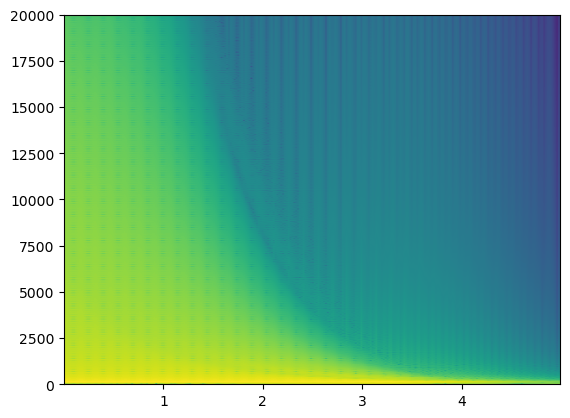

In [7]:
Pxx, freqs, bins, im = plt.specgram(filtered_wave, NFFT=1028, Fs=samplerate)
x1, x2, y1, y2 = plt.axis()
#plt.semilogy()
plt.axis((x1, x2, 0, 20000))
plt.show()

In [8]:

from matplotlib import cm # colour map 
%matplotlib tk

# extract the spectrum
freq_bins, timestamps, spec = signal.spectrogram(filtered_wave, samplerate)

# 3d plot
fig = plt.figure()
ax = plt.axes(projection='3d')
#colormaps: viridis, plasma, inferno, magma, cividis
ax.plot_surface(timestamps[None, :], freq_bins[:, None], 10.0*np.log10(spec), cmap=cm.cividis)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Frequency (Hz)")
ax.set_zlabel("Power (dB)")
plt.title("Sawtooth Sweep 3D Spectrogram")
plt.show()

## 3D cyclescope

In [9]:
number_cycles = wave_freq * duration # 100Hz * 5sec = 5000 cycles
cycle_period = 1 / wave_freq #10msec
cycle_samps = cycle_period * samplerate #480 samples
total_samps = duration * samplerate #240000 samples

cycle_split = np.split(filtered_wave, number_cycles)

import plotly.graph_objects as go
#fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig = go.Figure(data=[go.Surface(z=cycle_split, opacity=0.8)])
fig.update_layout(title='Saw Sweep (Time Domain)')
fig.show(renderer="browser")

## Saw Sweep Audio (model with feedback)

In [21]:
# user variables
wave_freq = 100.0 #Hz
cycles = 5
samplerate = 48000

# conversions / calculations
duration = 5
duration_ms = duration * 1000.0 #msec
lengthInSamps = math.ceil(duration * samplerate)

# create time axis
time = np.linspace(0, duration, lengthInSamps)

# choose a waveform
wave = signal.sawtooth(2.0*np.pi*wave_freq*time)
#wave = signal.square(2.0*np.pi*wave_freq*time, duty=(2.0*np.pi*time + 1)/2)

# create cutoff sweep
cutoff = np.geomspace(20000.0, 20.0, lengthInSamps)




# filter parameters
input_gain = 1.3
r = 1.6 # resonance (0.0 to 4.0)
fbk = 12.0
b = 0.8 # negative bias on headphone / ext amplifier (feedback)

boosted_wave = wave * input_gain

# highpass filter
Fc_hp = 8.0
g_hp = Fc_hp * np.pi / samplerate


# initial values
y = np.array([0.0, 0.0, 0.0, 0.0, 0.0])  # inital guess
errorThresh = 0.000001 # max NR error (stopping condition)
maxIter = 0
filtered_wave = np.zeros(len(boosted_wave))

# state values (initially zero)
s1 = 0.0
s2 = 0.0
s3 = 0.0
s4 = 0.0
s5 = 0.0

# NR loop
for n in range(len(boosted_wave)):
    
    g = cutoff[n] * np.pi / samplerate
    
    # input (current sample)
    x = boosted_wave[n]
    
    i = 0
    residue = 100 # something large
    while(abs(residue) > errorThresh and i < 50):
        # pre-compute tanh functions
        tanh_x = np.tanh(x-r*y[3]+y[4])
        tanh_y1 = np.tanh(y[0])
        tanh_y2 = np.tanh(y[1])
        tanh_y3 = np.tanh(y[2])
        tanh_y4 = np.tanh(y[3])
        tanh_y5 = np.tanh(fbk*(y[3]-b))
        
        # F(y) using current y values
        y1 = g*(tanh_x-tanh_y1) + s1 - y[0]
        y2 = g*(tanh_y1-tanh_y2) + s2 - y[1]
        y3 = g*(tanh_y2-tanh_y3) + s3 - y[2]
        y4 = g*(tanh_y3-tanh_y4) + s4 - y[3]
        y5 = tanh_y5 - (s4 / (1.0 - g_hp)) - y[4]
        F = np.array([y1, y2, y3, y4, y5]).T

        # pre-compute re-used algebra (helper "functions")
        help_x = 1.0 - (tanh_x * tanh_x)
        help_y1 = 1.0 - (tanh_y1 * tanh_y1)
        help_y2 = 1.0 - (tanh_y2 * tanh_y2)
        help_y3 = 1.0 - (tanh_y3 * tanh_y3)
        help_y4 = 1.0 - (tanh_y4 * tanh_y4)
        help_y5 = 1.0 - (tanh_y5 * tanh_y5)
        
        # Jacobian Matrix        
        J = np.array([
            [(-g*help_y1 - 1.0), 0.0, 0.0, (g*-r*help_x), (g*help_x)],
            [(g*help_y1), (-g*help_y2-1.0), 0.0, 0.0, 0.0],
            [0.0, (g*help_y2), (-g*help_y3 - 1.0), 0.0, 0.0],
            [0.0, 0.0, (g*help_y3), (-g*help_y4-1.0), 0.0],
            [0.0, 0.0, 0.0, (fbk*help_y5), -1.0]])

        # calculate next NR step
        y_est = y
        #y = y - np.matmul(inv(J), F)
        delta_y = np.linalg.solve(J, -1*F) # linear solver replaces the matrix inversion equation above
        y = delta_y + y            
        residue = y[3] - y_est[3] # only care about y4 residue

    # save y
    filtered_wave[n] = y[3]
    
    # update states
    s1 = 2.0 * y[0] - s1
    s2 = 2.0 * y[1] - s2
    s3 = 2.0 * y[2] - s3
    s4 = 2.0 * y[3] - s4
    s5 = 2.0 * y[4] - s5
    
    

# save audio
import scipy.io.wavfile as wav
wav.write("Saw_sweep.wav", samplerate, filtered_wave)